# Matching Chromaprint fingerprints

This notebook goes through a lot of details how you compare audio fingerprints generated by Chromaprint. Note that it contains a lot of statistics and I had very little knowledge about the more advanced statistics before I started working on this, so there might be mistakes. At the end, the matching works well though, so maybe it does not matter that much. :-)

All the examples below will use be using this [song](https://www.youtube.com/watch?v=NIA7os73T_0) and trying to find it in this [video](https://www.youtube.com/watch?v=wyrAUJCkDDc).

In [120]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import json

def load_fingerprint(name):
    return np.array(json.load(open('{}.json'.format(name)))['fingerprint'])

def index_to_s(i):
    return i * (4096 / 3) / 11025.0

fp1 = load_fingerprint('titan')
fp2 = load_fingerprint('keep_your_tips_up')

## Fingerprints

First we will look at what's actually inside the audio fingeprints that Chromaprint generates. Internally, the fingerprint is an array of 32-bit integer. These integers are hashes of some arbitrary audio features over a short period of time. There is a new hash every 0.1238 seconds and each hash covers the 2.6 seconds of audio. So for one minute long audio clip, we will get 463 hashes.

Although we rarely work with them in this form, the hashes look something like this:

In [49]:
fp1[:20]

array([3594440902, 3594416326, 3598545270, 3598528806, 3615303462,
       3615435574, 3589233430, 3589233495, 3622787783, 3622794949,
       3623867085, 3623862925, 3623867357, 3590189549, 3573346669,
       2499605615, 2498559022, 2490230894, 2490230910, 2490362974])

More commonly, we work with them on bit level. So it's more useful to think of the fingerprint as a 2D black-and-white image where each white pixel represents a 1 bit and each black pixel is a 0 bit:

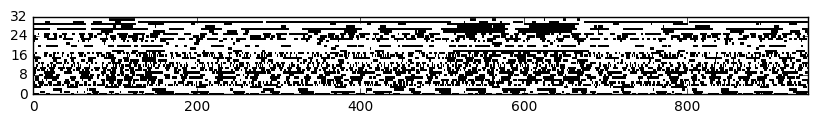

In [275]:
img = np.right_shift(np.bitwise_and(fp1[:,np.newaxis], np.left_shift(1, np.arange(32))), np.arange(32))

plt.figure(figsize=(10, 1))

plt.xlim(0, img.shape[0])
plt.ylim(0, img.shape[1])
plt.yticks(np.arange(0, 33, 8))
plt.imshow(img.T, interpolation='none', cmap='gray', aspect='auto')

The naive way to compare two fingerprints is to XOR the hashes and count the number of non-zero bits in the result. If you have two identical fingerprints, the result will be zero. If you have two compately different fingerprints, you will see around 50% split between zero and non-zero bits, i.e. the number of non-zero bits will be about 16 for every hash.

Let's have a look what happens if we compare our test fingerprints like this:

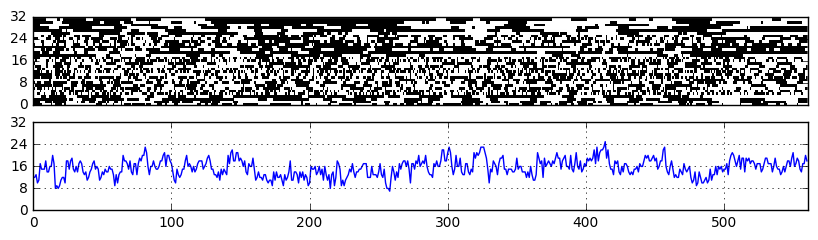

In [276]:
n = min(len(fp1), len(fp2))
fp_diff = np.bitwise_xor(fp1[:n], fp2[:n])
img = np.right_shift(np.bitwise_and(fp_diff[:,np.newaxis], np.left_shift(1, np.arange(32))), np.arange(32))

plt.figure(figsize=(10, 2.5))

ax = plt.subplot(2, 1, 1)
ax.get_xaxis().set_visible(False)
plt.xlim(0, img.shape[0])
plt.ylim(0, img.shape[1])
plt.yticks(np.arange(0, 33, 8))
ax = plt.imshow(img.T, interpolation='none', cmap='gray', aspect='auto')

plt.subplot(2, 1, 2)
plt.xlim(0, img.shape[0])
plt.ylim(0, img.shape[1])
plt.yticks(np.arange(0, 33, 8))
plt.grid(True)
plt.plot(np.sum(img, axis=1))

Based on this we might assume the fingerprints do not match, but that is incorrect, we just need a better way to compare them. The problem is that the fingerprints are not aligned properly.

## A closer look on the fingerprint hashes

Before we go into details on how to align fingerprints, let's have a look at some properties of the fingerprint hashes.

The hashes were designed so that on average each bit has equal chance of being either 0 or 1, which means they are uniformly distributed.

Bits also do not depend on each other. That is, if one bit is set, it has very low impact on the probability for another bit to be set.

Neither of these properties are perfectly implemented, some bits are better than others. The hashing algorithm parameters were learned using an [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost) training process. You will see that this caused some relationship between odd and even bits. It does not effect the overal performance much, but it's good to be aware of this.

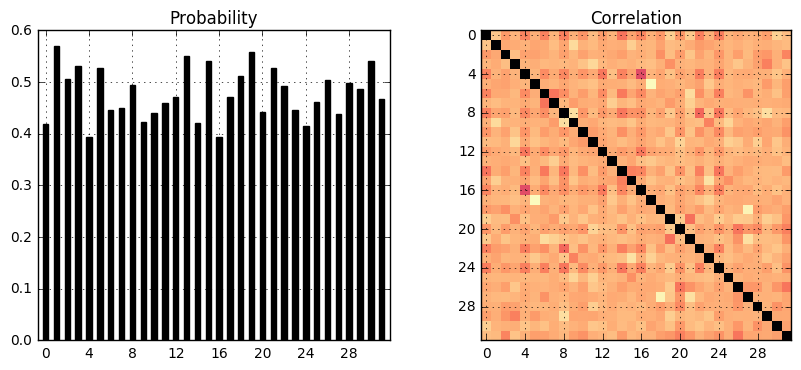

In [277]:
bitstats = np.load(open('bitstats.npz'))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Probability')
plt.bar(np.arange(32) - 0.25, bitstats['bits'], width=0.5, color='black')
plt.xlim(-0.75, 31.75)
plt.xticks(np.arange(0, 32, 4))
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Correlation')
plt.imshow(bitstats['xor_bits'], aspect=1, interpolation='none', cmap='magma')
plt.xticks(np.arange(0, 30, 4))
plt.yticks(np.arange(0, 30, 4))
plt.grid(True)

Some parts of the matching algorithm will not work with full 32-bit hashes to improve robustness. Because odd bits have better distribution, we will prefer those. And if we have to use even bits, we will prefer the higher ones.

In [278]:
0.5 - np.array([np.mean(bitstats['bits']), np.mean(bitstats['bits'][1::2]), np.mean(bitstats['bits'][::2])])

array([ 0.02200448,  0.00569244,  0.03831651])

## Aligning fingerprints

As we have seen, if the fingerprints do not start at the same time, we need to align them first.

We will use a small subset of bits from the hashes and cross-match the two fingerprints. For each hash that appears in both fingerprints, we will calculate the difference of offsets at which they appear in the fingerprints. We will build a histogram of these offset differences, do some filtering (effectively estimating a density function using gaussian kernels) and find peaks in it.

The peaks will tell us how do we need to align the two fingerprints to find matching segments in them. For example, a peak at offset 10 means that we need to shift the first fingerprint to the left by 10 items. That is, when doing a more detailed comparison, we will be effectively comparing `fp1[10+i]` and `fp2[i]`.

(array([243,  71, 329, 588, 760]),
 array([ 30.08571429,   8.79047619,  40.73333333,  72.8       ,  94.0952381 ]))

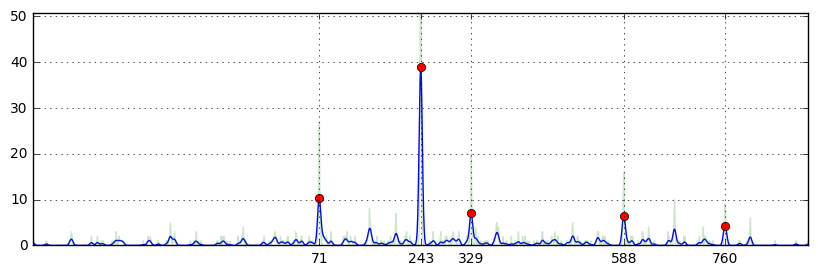

In [405]:
from collections import defaultdict
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import argrelmax

def align_fingerprints(fp1, fp2, nbits=12):
    bits = np.concatenate([np.arange(0, 32, 2), np.arange(1, 32, 2)])[::-1][:nbits]
    mask = np.sum(np.left_shift(1, bits))

    abs_offsets = defaultdict(list)
    for i, x in enumerate(fp1):
        abs_offsets[x & mask].append(i + 1)
    for i, x in enumerate(fp2):
        abs_offsets[x & mask].append(-(i + 1))

    rel_offsets = defaultdict(int)
    for hash_abs_offsets in abs_offsets.values():
        if len(hash_abs_offsets) <= 1:
            continue
        for o1 in hash_abs_offsets:
            if o1 <= 0:
                continue
            for o2 in hash_abs_offsets:
                if o2 >= 0:
                    continue
                rel_offsets[o1 + o2] += 1

    mn = min(rel_offsets.keys())
    mx = max(rel_offsets.keys())
    
    offsets = np.arange(mn, mx + 1)

    raw_counts = np.zeros(1 + mx - mn)
    for offset, count in rel_offsets.items():
        raw_counts[offset - mn] = count
        
    # filter the histogram to squash neighbor offset clusters into a single peak
    counts = gaussian_filter1d(raw_counts, 2.5)
    
    # locate peaks in the smoothed histogram
    peaks, = argrelmax(counts, order=3)
    
    # filter out peaks that are less than 10% of the top peak
    threshold = np.max(counts) * 0.1
    peaks = peaks[counts[peaks]>threshold]
    
    # sort them and only keep the top 10
    peaks = peaks[np.argsort(-counts[peaks])][:10]

    return offsets, counts, raw_counts, peaks

offsets, counts, raw_counts, peaks = align_fingerprints(fp1, fp2)

plt.figure(figsize=(10, 3))
plt.plot(offsets, counts)
plt.plot(offsets, raw_counts, alpha=0.2)
plt.plot(offsets[peaks], counts[peaks], 'o')
plt.xlim(offsets[0], offsets[-1])
plt.ylim(0, np.max(counts) * 1.3)
plt.xticks(offsets[peaks])
plt.grid(True)

offsets[peaks], index_to_s(offsets[peaks])

As you can see, the top peak is at offset 243 which is about 30.1 seconds from the beginning of `fp1`. That means we have to discard the first 243 from `fp1` and then `fp1[i]` should be comparable to `fp2[i]`. We will also truncate both fingerprints to the same length to make things easier.

In [288]:
afp1, afp2 = fp1, fp2

offset = offsets[peaks][0]
if offset > 0:
    afp1 = afp1[offset:]
elif offset < 0:
    afp2 = afp2[-offset:]

n = min(len(afp1), len(afp2))
afp1 = afp1[:n]
afp2 = afp2[:n]

If we do the XOR comparison again on the aligned fingerprints, we will see a darker region between 180 and 360. That means the fingerprints are similar there. In fact, there are actually more matching regions. The one between 100 and 180 matches poorly, but there are still some similarities. And there is maybe short one around 480. Our job now is to locate the regions programaticaly.

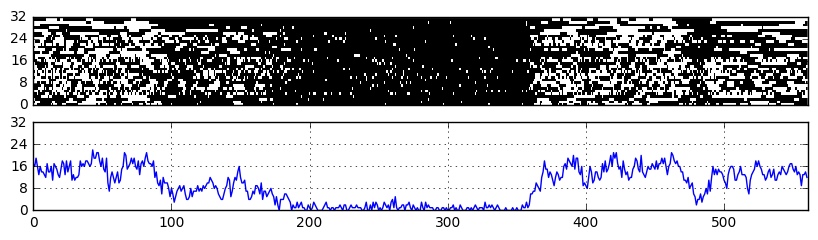

In [290]:
fp_diff = np.bitwise_xor(afp1, afp2)
img = np.right_shift(np.bitwise_and(fp_diff[:,np.newaxis], np.left_shift(1, np.arange(32))), np.arange(32))

plt.figure(figsize=(10, 2.5))

ax = plt.subplot(2, 1, 1)
ax.get_xaxis().set_visible(False)
plt.xlim(0, img.shape[0])
plt.ylim(0, img.shape[1])
plt.yticks(np.arange(0, 33, 8))
ax = plt.imshow(img.T, interpolation='none', cmap='gray', aspect='auto')

plt.subplot(2, 1, 2)
plt.xlim(0, img.shape[0])
plt.ylim(0, img.shape[1])
plt.yticks(np.arange(0, 33, 8))
plt.grid(True)
plt.plot(np.sum(img, axis=1))

## Finding matching regions

This is the part of the process that took me the longest to figure out. I have tried many different approaches over the time and was never happy with the results. That's the reason AcoustID currently uses a very naive method of comparing fingerprints and why I never included fingerprint matching the Chromaprint library.

My previous attempts always resulted in a lot of arbitrary thresholds and handling of special cases, which is not a good way to do this reliably. The version below still has some fixed thresholds, but these were automatically trained on a custom-built data set, but more importantly, they are not too critical.

The algorithm is basically a modifyied 1D version of the [Canny edge detector](https://en.wikipedia.org/wiki/Canny_edge_detector). We take the bit error rates and apply a gaussian filter with a relatively large kernel. The result is a very smooth curve. Now we take the gradient of that and find the local minima/maxima. These are our candidates for region boundaries.

The problem is that we will have too many candidates due to the noisy nature of the data. We could reduce the number by using even larger kernel for the filtering, but then we might start losing some details. Instead we will filter the list of candidates using additional features. More specifically, we will find the mid points between a candidate and its previous and next neighbors. We calculate the gradient between the filtered bit error rates at those mid points and we also calculate the distance between them. The gradient is divided by bit error rate, to emphasize differences in small values (we do not care about a jump from 14 to 18, but we do care about a jump from 0 to 4). And finally we filter the candidates using a very small decision tree based on these two features.

This might still generate more boundaries that we would like, but the majority are boundaries that we care about. The rest is easy to filter our in the next steps.

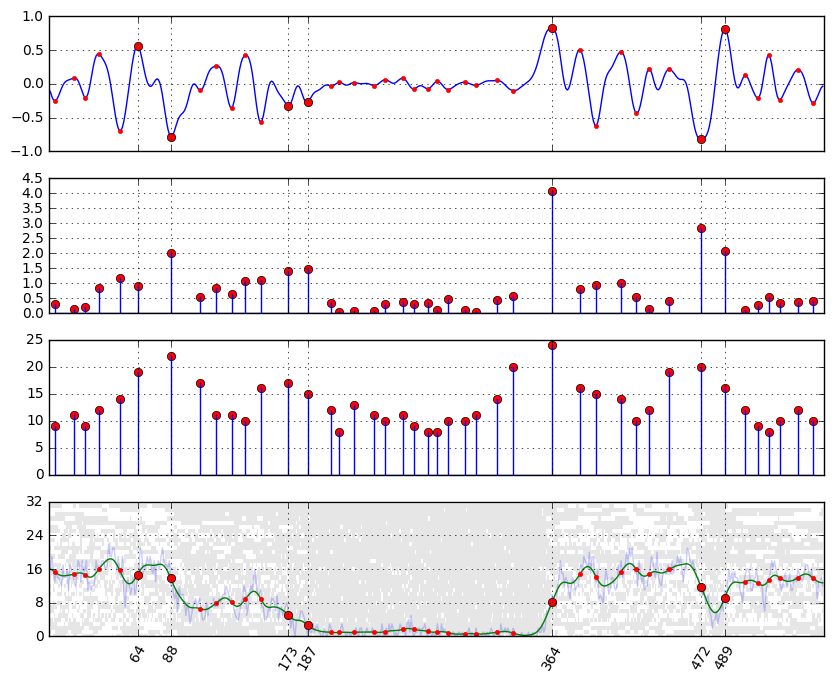

In [410]:
ber = np.sum(img, axis=1)
ber2 = gaussian_filter1d(ber.astype(float), 4.0)

gradient = np.gradient(ber2)
peaks, = argrelmax(np.abs(gradient), order=4)

mid_peaks = np.concatenate(([0], peaks, [len(ber)]))
mid_peaks = mid_peaks[:-1] + np.diff(mid_peaks) / 2

mid_gradient = np.abs(np.diff(ber2[mid_peaks])) / (1 + ber2[peaks] / 4)
mid_distance = np.diff(mid_peaks)

top_peaks = peaks[np.logical_or(mid_gradient>=1.2, np.logical_and(mid_gradient>=0.6, mid_distance>=18))]

plt.figure(figsize=(10, 8))

ax = plt.subplot(4, 1, 1)
plt.xlim(0, img.shape[0])
plt.xticks(top_peaks)
ax.set_xticklabels([])
plt.grid(True)
plt.plot(gradient)
plt.plot(peaks, gradient[peaks], '.', color='red')
plt.plot(top_peaks, gradient[top_peaks], 'o', color='red')

ax = plt.subplot(4, 1, 2)
plt.xlim(0, img.shape[0])
plt.xticks(top_peaks)
ax.set_xticklabels([])
plt.grid(True)
plt.stem(peaks, mid_gradient, linefmt='b-', markerfmt='ro', basefmt='-')

ax = plt.subplot(4, 1, 3)
plt.xlim(0, img.shape[0])
plt.xticks(top_peaks)
ax.set_xticklabels([])
plt.grid(True)
plt.stem(peaks, mid_distance, linefmt='b-', markerfmt='ro', basefmt='-')

plt.subplot(4, 1, 4)
plt.xlim(0, img.shape[0])
plt.ylim(0, img.shape[1])
plt.yticks(np.arange(0, 33, 8))
plt.xticks(top_peaks, rotation=60)
plt.grid(True)
plt.imshow(img.T, interpolation='none', cmap='gray', aspect='auto', alpha=0.1)
plt.plot(ber, alpha=0.2)
plt.plot(ber2)
plt.plot(peaks, ber2[peaks], '.', color='red')
plt.plot(top_peaks, ber2[top_peaks], 'o', color='red')

## Scoring


[ 15.0625      17.25         8.04705882   4.           1.14689266
  14.78703704   6.76470588  13.34722222]
[  0.96969697   7.11111111  14.22222222]


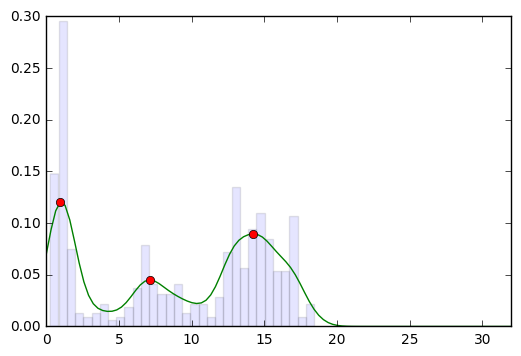

In [535]:
ber_ii = np.insert(np.cumsum(ber), 0, 0)

i0 = np.insert(top_peaks, 0, 0)
i1 = np.append(top_peaks, len(ber))

mean_ber_per_region = (ber_ii[i1] - ber_ii[i0]) * 1.0 / (i1 - i0)

print mean_ber_per_region

from scipy.stats import gaussian_kde
from scipy.cluster.vq import kmeans, whiten

kernel = gaussian_kde(ber2, bw_method=0.15)
x = np.linspace(0, 32, 100)
y = kernel.evaluate(x)
levels = argrelmax(y, order=2)

plt.xlim(0, 32)
plt.hist(ber2, bins=32, normed=True, alpha=0.1)
plt.plot(x, y)
plt.plot(x[levels], y[levels], 'o')

print x[levels]

#from scipy.cluster.vq import kmeans, whiten
#kmeans(ber2, 4)

#print np.subtract(regions
#ber_ii[regions]
                  
#np.cumsum(np.array([1, 3, 5]))